In [1]:
import os
import time
from matplotlib import pyplot as plt
import torchvision
import torch
from pycocotools.coco import COCO
import cv2
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import utils_coco

In [2]:
# get all images containing given categories
coco = COCO('dataset/instances_train2017.json')
 
categories_train = utils_coco.get_train_categories()
catIds = coco.getCatIds(catNms=categories_train)

imgIds = []
for cat in catIds:
    imgIds += coco.getImgIds(catIds=cat)
    
annIds = coco.getAnnIds(imgIds=imgIds, catIds=catIds, iscrowd=None)
imgsAnns = coco.loadAnns(annIds)
imgsInfo = coco.loadImgs(imgIds)

imgsInfo = sorted(imgsInfo, key=lambda x: x["id"])
imgsAnns = sorted(imgsAnns, key=lambda x: x["image_id"])

loading annotations into memory...
Done (t=11.69s)
creating index...
index created!


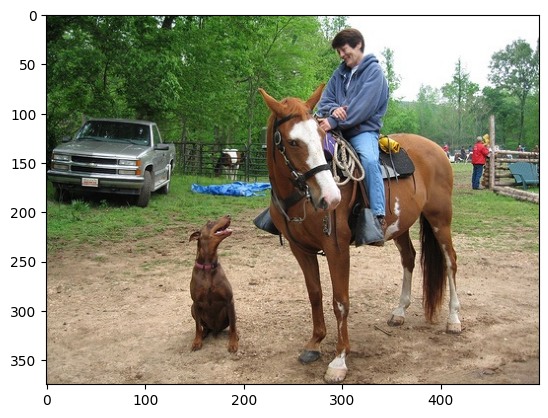

In [3]:
img = cv2.imread('horse.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [4]:
# Load names of classes and get random colors for them.
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
classes = coco_names
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')
# Give the configuration and weight files for the model and load the network.
net = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
#net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
# Show the network object
net

< cv2.dnn.Net 0x7fef17967c90>

Blob shape=(1, 3, 416, 416)


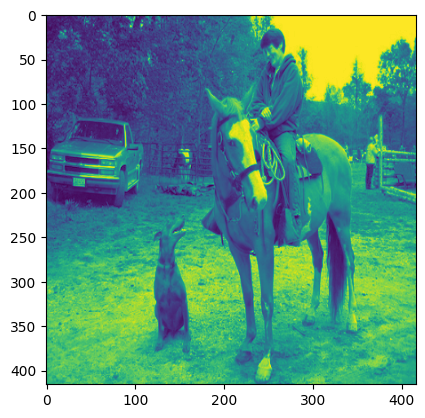

In [5]:
blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]

plt.imshow(r)
print('Blob shape=%s' % (blob.shape,))

In [6]:
ln = net.getLayerNames()
try:
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
except IndexError:
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
    
net.setInput(blob)
t0 = time.time()
outputs = net.forward(ln)
t = time.time()
print('It took %.3f seconds to process the image.' % (t-t0))

It took 1.730 seconds to process the image.


Image preview:


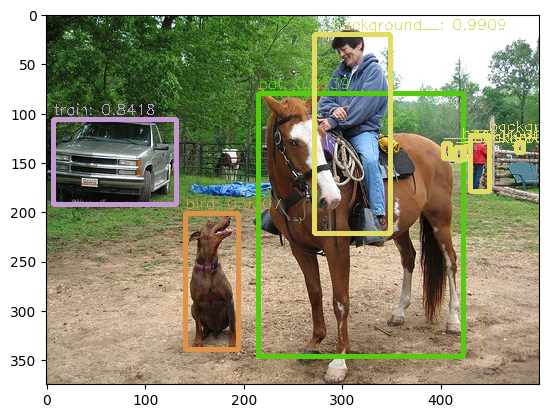

In [7]:
boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]
for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.5:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        
        #  -- Arguments for CV2 rectangle:
        # cv2.rect   (img,  x, y,   width, height, color, line width)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 4)
        
        # Labels and confidences for the image
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
print('Image preview:')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='none')